In [1]:
import sys
import inspect
from importlib import reload
from tqdm import tqdm
import glob

import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.constants import alpha, c, hbar, m_e, pi
from scipy.interpolate import RegularGridInterpolator, interp1d
import h5py

rcParams['figure.figsize'] = (6,4)
rcParams['font.size'] = 18

In [2]:
# energy = '8.86keV'
energy = 4.96
omega_c = energy*1000 # eV
data_path = f'../data/xfel-data/xfel_{energy}keV'
files = glob.glob(f'{data_path}/*')
filename = files[0]

## Check categories

In [3]:
def print_name(name, obj):
    if isinstance(obj, h5py.Dataset):
        print('Dataset:', name)
    elif isinstance(obj, h5py.Group):
        print('Group:', name)

with h5py.File(filename, 'r')  as h5f: # file will be closed when we exit from WITH scope
    h5f.visititems(print_name) # print all strustures names

Group: data
Dataset: data/arrEhor
Dataset: data/arrEver
Group: history
Group: history/parent
Group: history/parent/info
Dataset: history/parent/info/data_description
Dataset: history/parent/info/package_version
Group: history/parent/misc
Dataset: history/parent/misc/FAST2XYDAT
Dataset: history/parent/misc/angular_distribution
Dataset: history/parent/misc/gain_curve
Dataset: history/parent/misc/intensity
Dataset: history/parent/misc/nzc
Dataset: history/parent/misc/spectrum_xy0
Dataset: history/parent/misc/spot_size
Dataset: history/parent/misc/temporal_struct
Dataset: history/parent/misc/temporal_struct0
Group: misc
Dataset: misc/electricField
Dataset: misc/resizing
Group: params
Group: params/Mesh
Dataset: params/Mesh/hvx
Dataset: params/Mesh/hvy
Dataset: params/Mesh/hvz
Dataset: params/Mesh/nSlices
Dataset: params/Mesh/nvx
Dataset: params/Mesh/nvy
Dataset: params/Mesh/nvz
Dataset: params/Mesh/nx
Dataset: params/Mesh/ny
Dataset: params/Mesh/sliceMax
Dataset: params/Mesh/sliceMin
Datas

## Get field data

In [99]:
with h5py.File(filename, 'r')  as h5f:
    nt =   h5f['params/Mesh/nSlices'][()]
    tmin = h5f['params/Mesh/sliceMin'][()]
    tmax = h5f['params/Mesh/sliceMax'][()]
    intensity = h5f['history/parent/misc/intensity'][()] 
    xmin = h5f['params/Mesh/xMin'][()]
    xmax = h5f['params/Mesh/xMax'][()]
    ymin = h5f['params/Mesh/yMin'][()]
    ymax = h5f['params/Mesh/yMax'][()]
    nx = h5f['params/Mesh/nx'][()]
    ny = h5f['params/Mesh/ny'][()]
    nzc = h5f['history/parent/misc/nzc'][()]
    z0 = h5f['params/Mesh/zCoord'][()]
    
    Eh = h5f['data/arrEhor'][()]
    Ev = h5f['data/arrEver'][()]

    Eh_real, Eh_imag = Eh[:,:,:,0], Eh[:,:,:,1]
    Ev_real, Ev_imag = Ev[:,:,:,0], Ev[:,:,:,1]

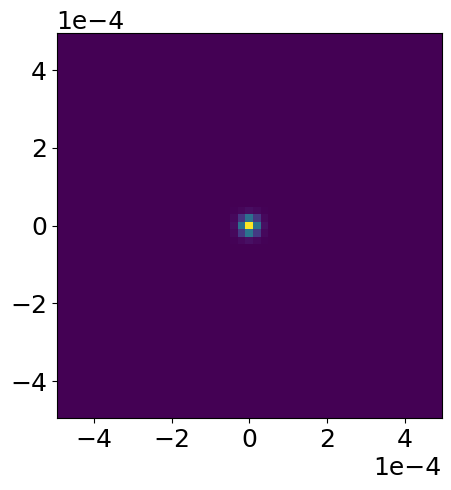

In [100]:
# create grids
x = np.linspace(xmin, xmax, nx, endpoint=True)
y = np.linspace(ymin, ymax, ny, endpoint=True)
t = np.linspace(tmin, tmax, nt, endpoint=True)
dx, dy, dt = [ax[1]-ax[0] for ax in (x,y,t)]

# plot intensity
plt.figure(figsize=(5,5))
plt.pcolormesh(y, x, intensity)
plt.gca().set_aspect('equal')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.show()

In [101]:
fs_to_eV = 1.519
mum_to_eV = 5.068

# Show that maximally resolved frequency is not higher than 8.86 keV
print(f'dt:        {dt*1e15:.5f} fs')
omega_max = 2*pi/(dt*1e15*fs_to_eV)
print(f'omega max: {omega_max/1e3:.5f} keV')

k_c_m = omega_c * mum_to_eV / 1e-6
xray_pw = 1e6 * np.cos(omega_c * t*1e15 * fs_to_eV)

# create time grid with better resolution
tx = np.linspace(t.min(), t.max(), 25*len(t))
dtx = tx[1] - tx[0]
omega_max = 2*pi/(dtx*1e15*fs_to_eV)
print(f'omega max: {omega_max/1e3:.5f} keV')

xray_pw2 = 1e6 * np.cos(omega_c * tx*1e15 * fs_to_eV)

dt:        0.00667 fs
omega max: 0.62046 keV
omega max: 15.51449 keV


In [60]:
print(1.39 / 16665)
print(dt*1e15)

8.340834083408341e-05
0.00666666994031831


In [61]:
tmin*1e15, tmax*1e15

(np.float64(-16.496674767321405), np.float64(16.496674767321405))

## 1d fft test

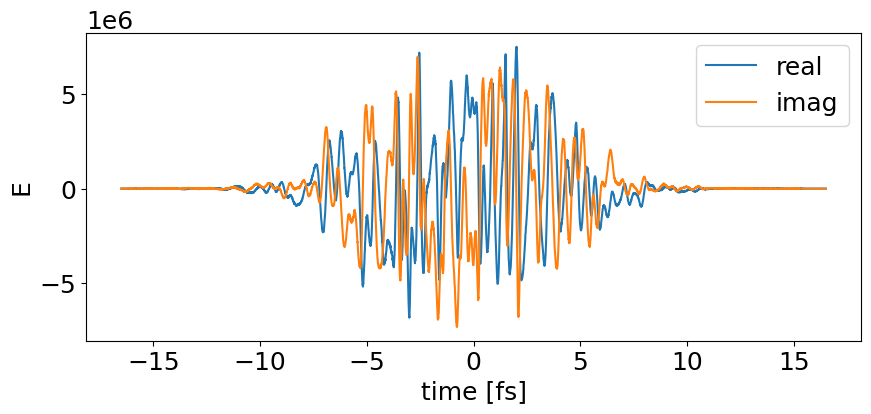

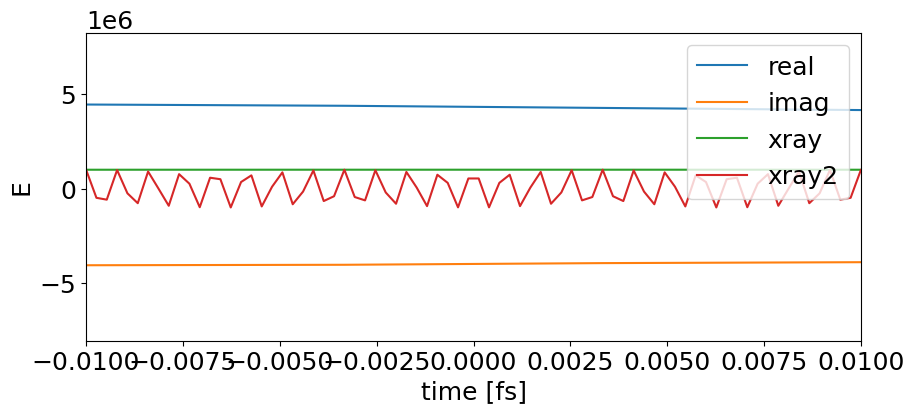

In [91]:
# plot fields
Ex_real = Eh[nx//2,ny//2,:,0]
Ex_imag = Eh[nx//2,ny//2,:,1]

plt.figure(figsize=(10,4))
plt.plot(t*1e15, Ex_real, label='real')
plt.plot(t*1e15, Ex_imag, label='imag')
plt.xlabel('time [fs]')
plt.ylabel('E')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(t*1e15, Ex_real, label='real')
plt.plot(t*1e15, Ex_imag, label='imag')
plt.plot(t*1e15, xray_pw, '-', label='xray')
plt.plot(tx*1e15, xray_pw2, '-', label='xray2')
plt.xlabel('time [fs]')
plt.ylabel('E')
plt.legend()
plt.xlim([-0.01,0.01])
plt.show()

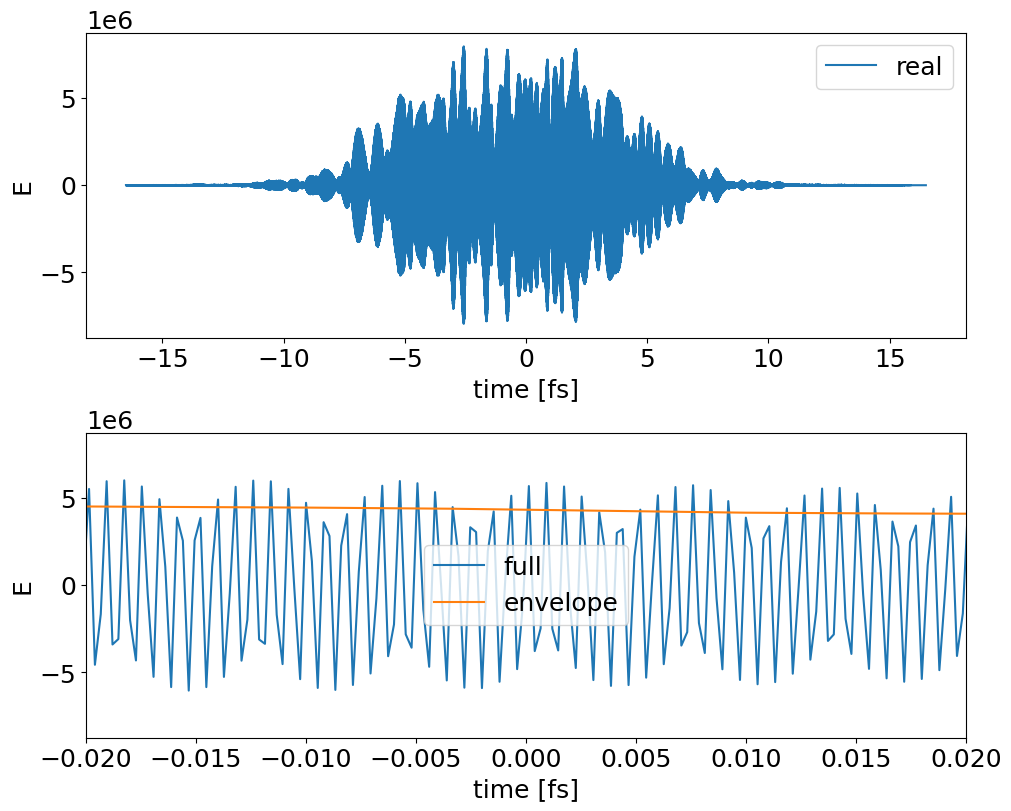

In [92]:
# Interpolate field data between time grids
Ex_interp = interp1d(t, Ex_real)
Ex_real_det = Ex_interp(tx)

Ex_interp = interp1d(t, Ex_imag)
Ex_imag_det = Ex_interp(tx)

# Combine fields
phase = omega_c * tx*1e15 * fs_to_eV
Ex_full = (Ex_real_det + 1j*Ex_imag_det) * np.exp(1j*phase)
# Ex_full = Ex_real_det * np.cos(phase) + Ex_imag_det * np.sin(phase)

plt.figure(figsize=(10,8), layout='constrained')
plt.subplot(2,1,1)
plt.plot(tx*1e15, Ex_full.real, label='real')
plt.xlabel('time [fs]')
plt.ylabel('E')
plt.legend()

plt.subplot(2,1,2)
plt.plot(tx*1e15, Ex_full.real, label='full')
plt.plot(t*1e15, Ex_real, label='envelope')
plt.xlabel('time [fs]')
plt.ylabel('E')
plt.legend()
plt.xlim([-0.02,0.02])
plt.show()

(4.86, 5.06)

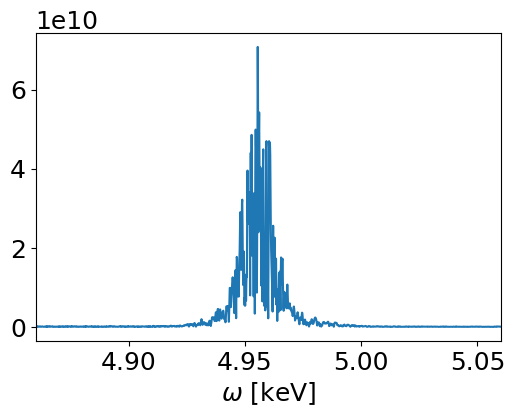

In [93]:
# fourier of full field
omega = np.fft.fftshift(2*pi*np.fft.fftfreq(len(tx), dtx)) / (1e15 * fs_to_eV) / 1000
Ex_f = np.fft.fftshift(np.fft.fft(Ex_full))

plt.plot(omega, abs(Ex_f))
plt.xlabel('$\\omega$ [keV]')
plt.xlim([energy-0.1,energy+0.1])

(-0.1, 0.1)

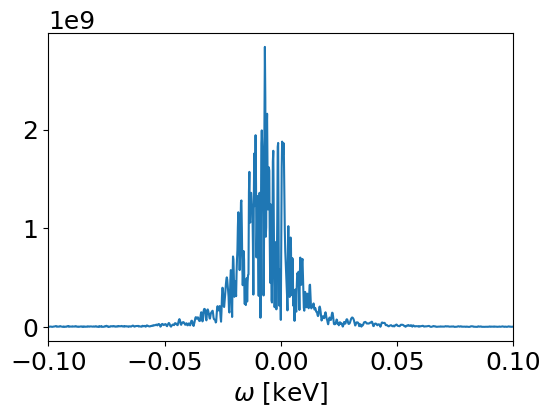

In [94]:
# fourier transform of the envelope
omega = np.fft.fftshift(2*pi*np.fft.fftfreq(len(t), dt)) / (1e15) / 1000
Ex_f = np.fft.fftshift(np.fft.fft(Ex_real + 1j*Ex_imag))

plt.plot(omega, abs(Ex_f))
plt.xlabel('$\\omega$ [keV]')
plt.xlim([-0.1,0.1])

## 3d FFT of the spectrum

In [95]:
Ex_real, Ex_imag = Eh[:,:,:,0], Eh[:,:,:,1]
Ex_full = Ex_real + 1j*Ex_imag

Ex_f = np.fft.fftn(Ex_full, axes=(0,1), norm='backward')
Ex_f = np.conj(np.fft.fftn(np.conj(Ex_f), axes=(2,), norm='backward'))
Ex_f = np.fft.fftshift(Ex_f)

kx_1d = 2.*pi*np.fft.fftfreq(x.size, dx)
ky_1d = 2.*pi*np.fft.fftfreq(y.size, dy)
k_1d = 2.*pi*np.fft.fftfreq(t.size, c*dt) + k_c_m
dkx, dky, dk = [ax[1]-ax[0] for ax in (kx_1d, ky_1d, k_1d)]
# omega_1d = 2.*pi*np.fft.fftfreq(t.size, dt)
# kx_1d, ky_1d, omega_1d = [np.fft.fftshift(ax) for ax in (kx_1d, ky_1d, omega_1d)]
kx_1d, ky_1d, k_1d = [np.fft.fftshift(ax) for ax in (kx_1d, ky_1d, k_1d)]

# omega_eV = omega_1d / (1e15 * fs_to_eV) / 1000
k_eV = k_1d / (1e6 * mum_to_eV) / 1000

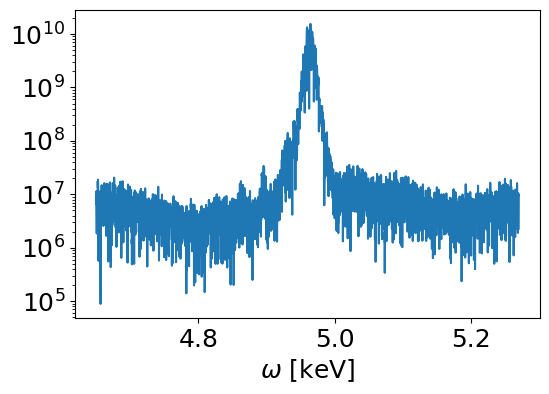

In [96]:
plt.figure()
plt.plot(k_eV, np.abs(Ex_f[nx//2, ny//2]))
# plt.plot(k_eV, np.abs(Ex_f[0,0]))
plt.xlabel('$\\omega$ [keV]')
plt.yscale('log')
# plt.xlim([-0.05, 0.05])
plt.show()

In [77]:
interpolator = RegularGridInterpolator((kx_1d, ky_1d, k_1d), Ex_f,
                                       bounds_error=False)

kz_1d = np.linspace(k_1d.min(), k_1d.max(), len(k_1d))
kx, ky, kz = np.meshgrid(kx_1d, ky_1d, kz_1d, indexing='ij', sparse=False)
k_for_kz = np.sqrt(kx**2 + ky**2 + kz**2)

data_pts = np.stack((kx, ky, k_for_kz), axis=-1)

Ex_kxyz = interpolator(data_pts) * kz / k_for_kz

In [83]:
dN_dE = np.sum(Ex_kxyz, axis=(0,1)) * dkx * dky

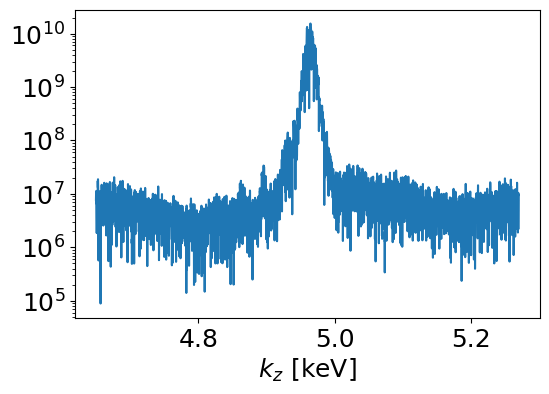

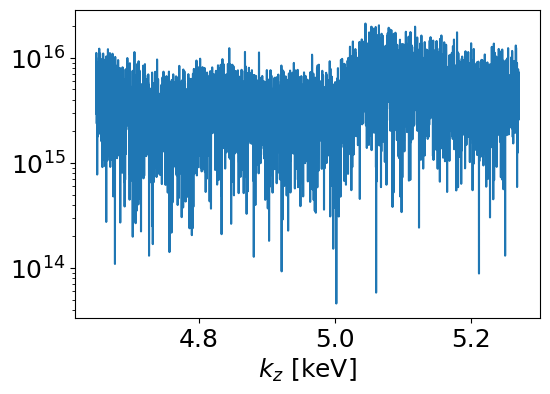

In [85]:
kz_eV = kz_1d / (1e6 * mum_to_eV) / 1000

plt.figure()
plt.plot(kz_eV, np.abs(Ex_kxyz[nx//2, ny//2]))
# plt.plot(kz_eV, np.abs(Ex_kxyz[-1,-1]))
# plt.plot(kz_eV, np.abs(dN_dE))
# plt.xlim([8.86-0.05, 8.86+0.05])
plt.yscale('log')
plt.xlabel('$k_z$ [keV]')

plt.show()

plt.figure()
plt.plot(kz_eV, np.abs(dN_dE))
# plt.xlim([8.86-0.05, 8.86+0.05])
plt.yscale('log')
plt.xlabel('$k_z$ [keV]')
plt.show()

In [49]:
# Create grids
x = np.linspace(xmin, xmax, nx, endpoint=True)
y = np.linspace(ymin, ymax, ny, endpoint=True)
t = np.linspace(tmin, tmax, nt, endpoint=True)
dx, dy, dt = [ax[1]-ax[0] for ax in (x,y,t)]

kx_ = 2.*pi*np.fft.fftfreq(x.size, dx)
ky_ = 2.*pi*np.fft.fftfreq(y.size, dy)
omega_ = 2.*pi*np.fft.fftfreq(t.size, dt)
k_ = 2.*pi*np.fft.fftfreq(t.size, c*dt)

kx_, ky_, omega_, k_ = [np.fft.fftshift(k) for k in (kx_, ky_, omega_, k_)]

# make meshgrids
# kx, ky, omega = np.meshgrid(kx_, ky_, omega_, indexing='ij', sparse=True)
kx, ky, k = np.meshgrid(kx_, ky_, k_, indexing='ij', sparse=True)
kz = np.sqrt(np.maximum(k**2 - kx**2 - ky**2, 0))
# kz_cart = np.linspace(0, omega.max(), len(omega))[None,None,:]
# omega_for_kz = np.sqrt(kx**2 + ky**2 * kz_cart**2)

Ex = Eh[:,:,:,0] + 1j*Eh[:,:,:,1]
# nx, ny, nt = Ex.shape

# do Fourier transform for the field
# 1) regular forward FFT for x-y axis
# 2) forward FFT for t axis of E* to have forward FFT with opposite sign
Ex_f = np.fft.fftn(Ex, axes=(0,1), norm='backward')
Ex_f = np.fft.fftn(np.conj(Ex_f), axes=(2,), norm='backward')
Ex_f = np.fft.fftshift(np.conj(Ex_f))
print(Ex_f.shape)

# (kx,ky,omega) -> (kx,ky,kz) but kz is not cartesian
# Ex_f_kxyz = kz/k * np.exp(-1j*kz*z0) * Ex_f
# Ex_f_kxyz = np.nan_to_num(Ex_f_kxyz)

# Concatenate with E[...,kz<0] = 0
kz_cart = np.linspace(0, k_.max(), len(k_))
kz_eV = hbar * kz_cart * c / 1.6e-19
kx, ky, kz = np.meshgrid(kx_, ky_, kz_cart, indexing='ij', sparse=False)

# omega_kz = c*np.sqrt(kx**2 + ky**2 + kz**2)
k_kz = np.sqrt(kx**2 + ky**2 + kz**2)

(51, 51, 13392)


In [50]:
# Build interpolator
interpolator = RegularGridInterpolator((kx_, ky_, k_), Ex_f,
                                       bounds_error=False)

# Interpolate on cartesian kz grid
data_pts = np.stack((kx, ky, k_kz), axis=-1)
Ex_f_kxyz_cart = interpolator(data_pts)

In [53]:
Ex_f_kxyz_cart.shape

(51, 51, 13392)

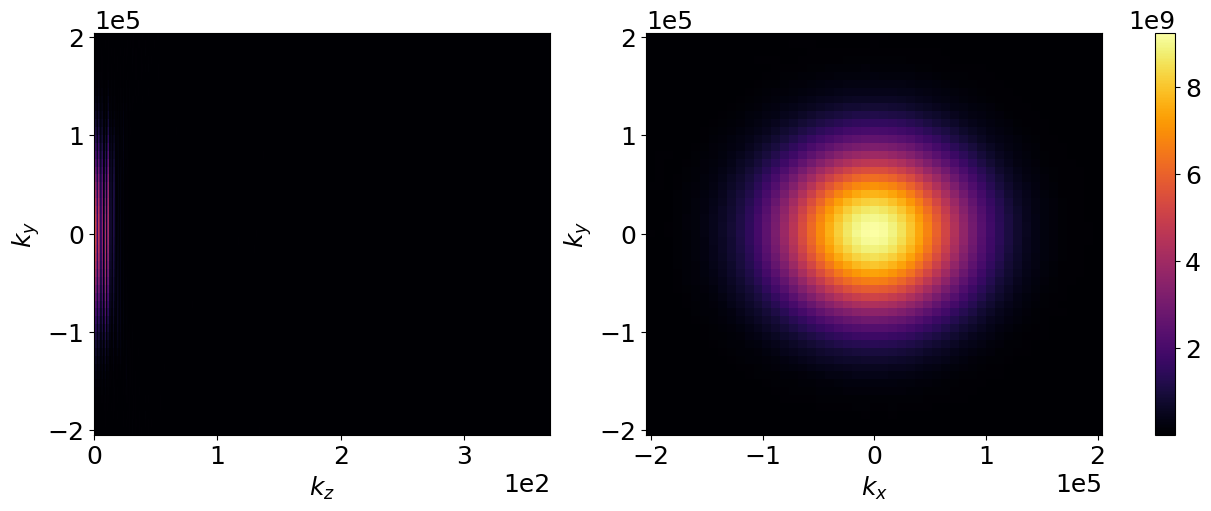

In [51]:
idx_max = np.argmax(Ex_f_kxyz_cart[nx//2,ny//2])

plt.figure(figsize=(12,5), layout='constrained')
ax = plt.subplot(1,2,1)
plt.pcolormesh(kz_eV, ky_, np.abs(Ex_f_kxyz_cart[nx//2]), cmap='inferno')
plt.xlabel('$k_z$')
plt.ylabel('$k_y$')
ax.ticklabel_format(style='sci', scilimits=(0,0))

ax = plt.subplot(1,2,2)
plt.pcolormesh(kx_, ky_, np.abs(Ex_f_kxyz_cart[:,:,idx_max]), cmap='inferno')
plt.colorbar()]
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
ax.ticklabel_format(style='sci', scilimits=(0,0))
plt.show()

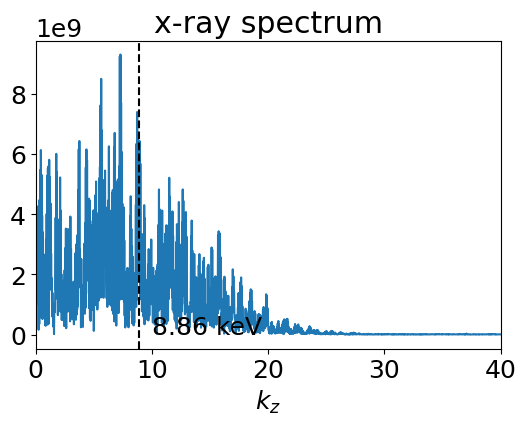

In [52]:
plt.figure()
plt.plot(kz_eV, np.abs(Ex_f_kxyz_cart[nx//2, ny//2]))
plt.axvline(8.86, linestyle='--', color='black')
plt.xlabel("$k_z$")
plt.xlim([0,40])
plt.title('x-ray spectrum')
plt.text(10, 20, "8.86 keV")
plt.show()

In [18]:
xmin, xmax, nx

(-0.001167432521469891, 0.001167432521469891, 51)

In [28]:
E0_complex = Eh[:,:,:,0] + 1j*Eh[:,:,:,1]

In [29]:
Eh_real, Eh_imag = Eh[:,:,:,0], Eh[:,:,:,1]
Eh_real.shape

Ev_real, Ev_imag = Ev[:,:,:,0], Ev[:,:,:,1]
Ev_real.shape

(51, 51, 13392)

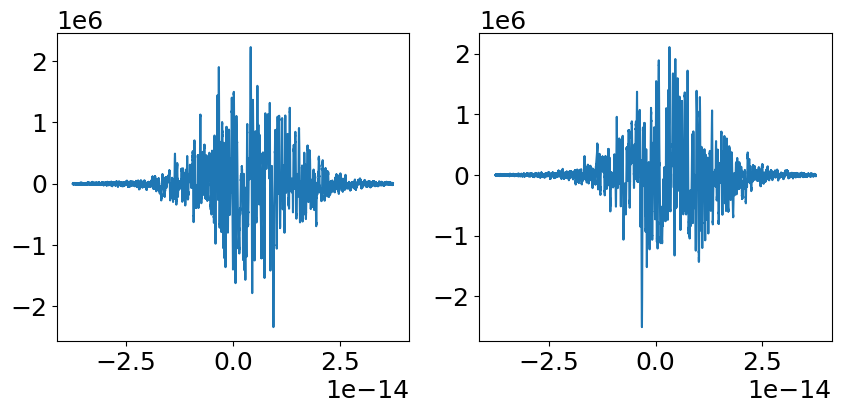

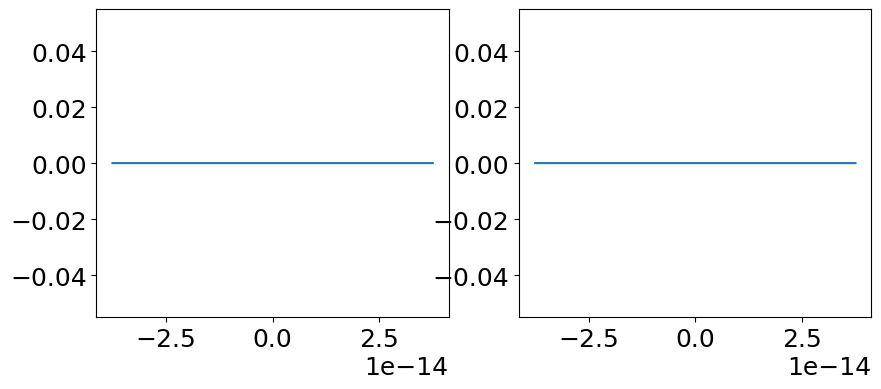

In [38]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t, Eh_real[nx//2, ny//2,:])

plt.subplot(1,2,2)
plt.plot(t, Eh_imag[nx//2, ny//2,:])
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t, Ev_real[nx//2, ny//2,:])

plt.subplot(1,2,2)
plt.plot(t, Ev_imag[nx//2, ny//2,:])
plt.show()

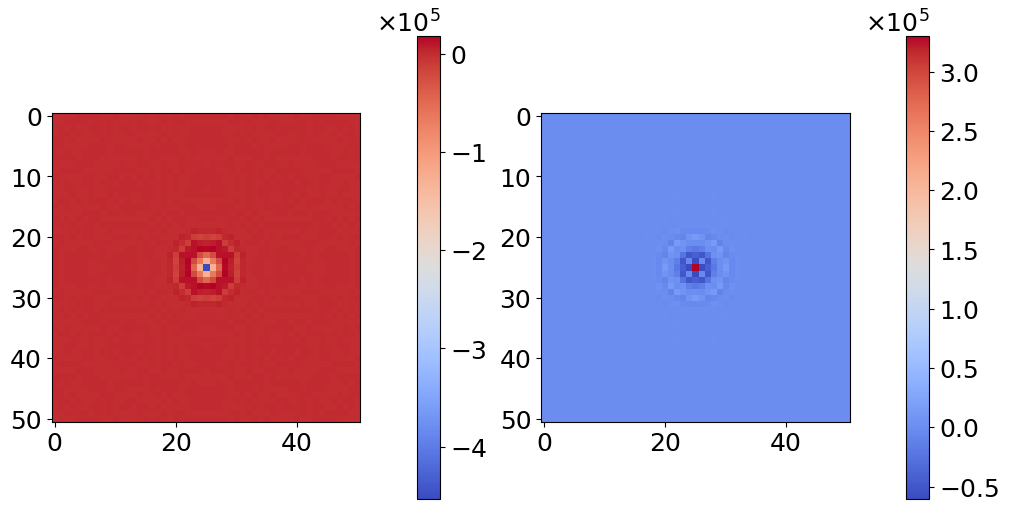

In [22]:
idx = nt // 2#100*2

plt.figure(figsize=(10,5), layout='constrained')
for i,data in enumerate([Eh_real, Eh_imag]):
    plt.subplot(1,2,i+1)
    plt.imshow(data[:,:,idx], cmap='coolwarm')
    cbar = plt.colorbar()
    cbar.formatter.set_powerlimits((0, 0))
    cbar.formatter.set_useMathText(True)
plt.show()

## Plot the data

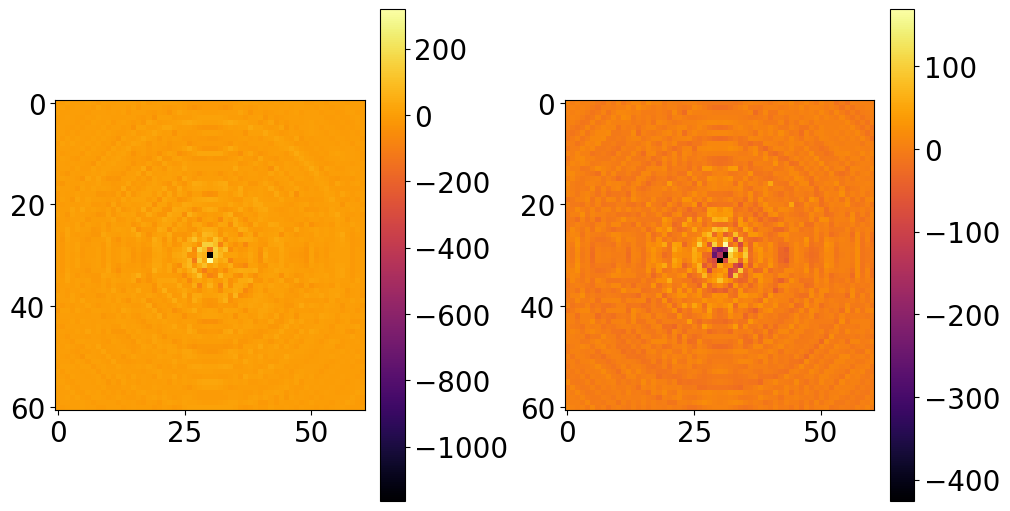

In [115]:
idx = 200

plt.figure(figsize=(10,5), layout='constrained')
for i,data in enumerate([Eh_real, Eh_imag]):
    plt.subplot(1,2,i+1)
    plt.imshow(data[:,:,idx], cmap='inferno')
    plt.colorbar()
plt.show()

In [117]:
temporal_struct.shape

(3629, 2)

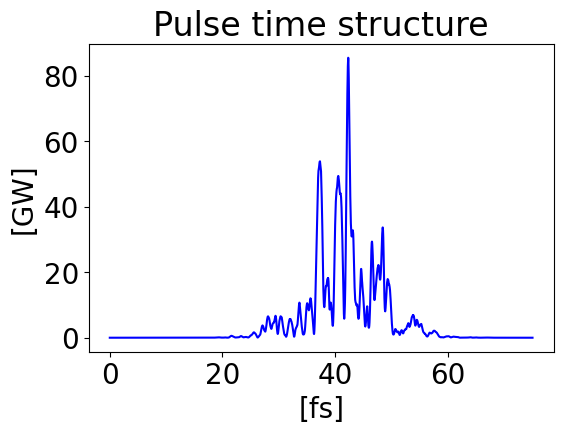

In [118]:
plt.plot(temporal_struct[:,0],temporal_struct[:,1]*1e-9,'b-')
plt.title('Pulse time structure')
plt.xlabel('[fs]')
plt.ylabel('[GW]')
plt.show()